In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import *

In [2]:
import glob
quarterly_bikeshare_data = []
bikeshare_files = glob.glob('data/metro-bike-share*.csv')
for quarter in bikeshare_files:
    quarterly_bikeshare_data.append(pd.read_csv(
        quarter,
        parse_dates=True,
        index_col='start_time'
    ))
    
bikeshare = pd.concat(quarterly_bikeshare_data, sort=False)
bikeshare.head()

,trip_id,duration,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station_id,end_station_id,bike_type
start_time,,,,,,,,,,,,,,,,
2018-01-01 00:04:00,65406367,21,2018-01-01 00:25:00,3063.0,34.049198,-118.252831,3018.0,34.043732,-118.260139,5889,0.0,One Way,Walk-up,NaN,NaN,NaN
2018-01-01 00:05:00,65406366,20,2018-01-01 00:25:00,3063.0,34.049198,-118.252831,3018.0,34.043732,-118.260139,6311,0.0,One Way,Walk-up,NaN,NaN,NaN
2018-01-01 00:06:00,65406365,19,2018-01-01 00:25:00,3063.0,34.049198,-118.252831,3018.0,34.043732,-118.260139,5753,0.0,One Way,Walk-up,NaN,NaN,NaN
2018-01-01 00:13:00,65406364,22,2018-01-01 00:35:00,3018.0,34.043732,-118.260139,3031.0,34.044701,-118.252441,6220,30.0,One Way,Monthly Pass,NaN,NaN,NaN
2018-01-01 00:14:00,65406362,45,2018-01-01 00:59:00,4204.0,33.988419,-118.451630,4216.0,34.023392,-118.479637,12436,30.0,One Way,Monthly Pass,NaN,NaN,NaN


In [3]:
len(bikeshare)

639786

In [4]:
daily = bikeshare.groupby(pd.Grouper(freq='D')).count()
daily['Total'] = daily['trip_id']
daily = daily[['Total']] # remove other columns

In [5]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [6]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun
start_time,,,,,,,,
2016-07-07,190,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2016-07-08,345,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2016-07-09,421,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2016-07-10,334,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2016-07-11,350,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2015', '2019')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

In [8]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday
start_time,,,,,,,,,
2016-07-07,190,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2016-07-08,345,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2016-07-09,421,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2016-07-10,334,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2016-07-11,350,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(8, 17)

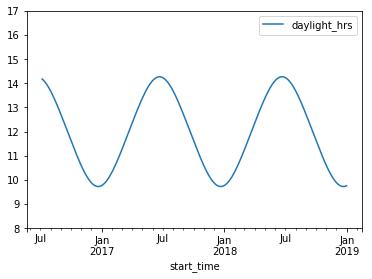

In [9]:
def hours_of_daylight(date, axis=23.44, latitude=34.05):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

In [10]:
weather = pd.read_csv('data/DTLA_weather.csv', index_col='DATE', parse_dates=True)
weather['Temp (F)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

daily = daily.join(weather[['PRCP', 'Temp (F)']])

In [11]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [12]:
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'Temp (F)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression()
model.fit(X, y)
daily['predicted'] = model.predict(X)

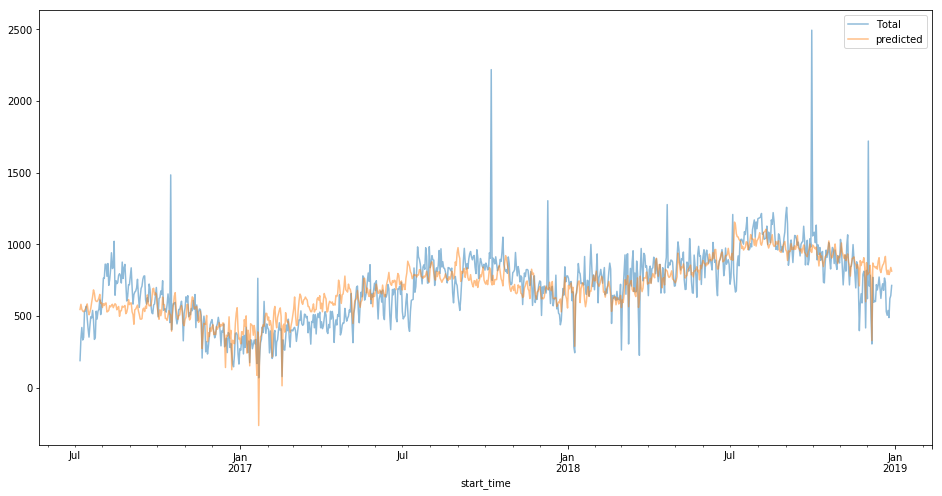

In [13]:
daily[['Total', 'predicted']].plot(alpha=0.5, figsize=(16,8));

In [14]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon             -25.199639
Tue               6.763238
Wed              -0.751349
Thu              14.287890
Fri              38.662040
Sat             -13.036020
Sun             -20.726160
holiday         -57.660206
daylight_hrs     10.050900
PRCP           -237.677624
Temp (F)         11.220398
annual          199.980282
dtype: float64

In [15]:
from sklearn.utils import resample
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

With these errors estimated, let's again look at the results:

In [16]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
Mon            -25.0   11.0
Tue              7.0   10.0
Wed             -1.0   10.0
Thu             14.0   11.0
Fri             39.0   11.0
Sat            -13.0   13.0
Sun            -21.0   21.0
holiday        -58.0   37.0
daylight_hrs    10.0    4.0
PRCP          -238.0   38.0
Temp (F)        11.0    1.0
annual         200.0    8.0


In [17]:
ciclavia_dates = pd.to_datetime([
    '2016-8-14',
    '2016-10-16',
    '2017-3-26',
    '2017-6-11',
    '2017-8-13',
    '2017-10-8',
    '2017-12-10',
    '2018-4-22',
    '2018-6-24',
    '2018-9-30',
    '2018-12-02'
    
])

In [18]:
daily['ciclavia'] = 0
for date in ciclavia_dates:
    daily.at[date, 'ciclavia'] = 1

In [19]:
column_names.append('ciclavia')
X = daily[column_names]
y = daily['Total']

modelvia = LinearRegression()
modelvia.fit(X, y)
daily['predicted'] = modelvia.predict(X)

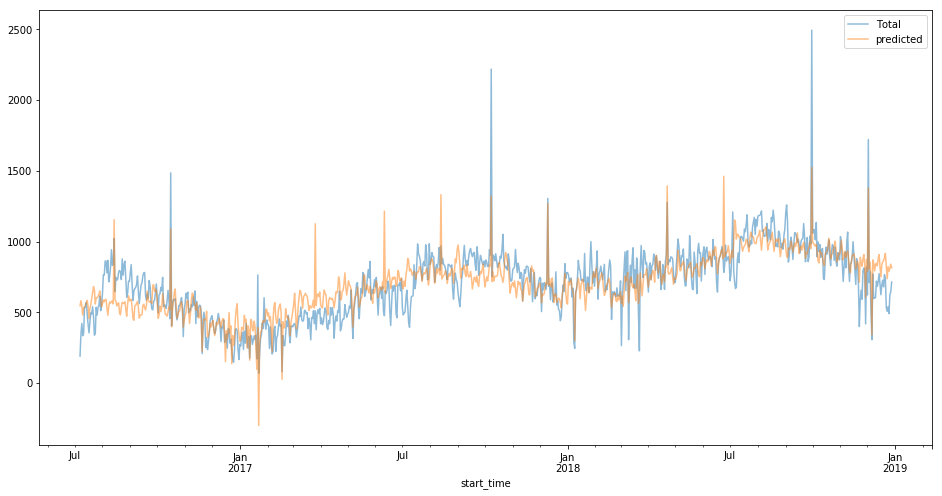

In [20]:
daily[['Total', 'predicted']].plot(alpha=0.5, figsize=(16,8));

In [21]:
params = pd.Series(modelvia.coef_, index=X.columns)
params

Mon             -17.382332
Tue              14.571654
Wed               7.049859
Thu              21.885685
Fri              46.218917
Sat              -5.212053
Sun             -67.131730
holiday         -58.127211
daylight_hrs      9.459815
PRCP           -232.345461
Temp (F)         11.188904
annual          199.193916
ciclavia        634.858568
dtype: float64

In [22]:
from sklearn.utils import resample
err = np.std([modelvia.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

In [23]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
Mon            -17.0   10.0
Tue             15.0    9.0
Wed              7.0    9.0
Thu             22.0   10.0
Fri             46.0   11.0
Sat             -5.0   12.0
Sun            -67.0   12.0
holiday        -58.0   37.0
daylight_hrs     9.0    3.0
PRCP          -232.0   43.0
Temp (F)        11.0    1.0
annual         199.0    7.0
ciclavia       635.0  172.0
